In [1]:
import os
from typing import Callable, Optional

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import torch
import torch.nn.functional as F
from PIL import Image
from torch import Tensor, nn
from torch.optim import Adam
from torch.utils.data import DataLoader, RandomSampler
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torchvision.utils import save_image

device = torch.device("cuda")


In [2]:
# reference: https://stackoverflow.com/questions/14465297/connected-component-labeling-implementation
# perform depth first search for each candidate/unlabeled region
dx = [+1, 0, -1, 0]
dy = [0, +1, 0, -1]

def dfs(mask: npt.NDArray, x: int, y: int, labels: npt.NDArray, current_label: int):
    n_rows, n_cols = mask.shape
    if x < 0 or x == n_rows:
        return
    if y < 0 or y == n_cols:
        return
    if labels[x][y] or not mask[x][y]:
        return  # already labeled or not marked with 1 in image

    # mark the current cell
    labels[x][y] = current_label

    # recursively mark the neighbors
    for direction in range(4):
        dfs(mask, x + dx[direction], y + dy[direction], labels, current_label)


def find_components(mask: npt.NDArray):
    label = 0

    n_rows, n_cols = mask.shape
    labels = np.zeros(mask.shape, dtype=np.int8)

    for i in range(n_rows):
        for j in range(n_cols):
            if not labels[i][j] and mask[i][j]:
                label += 1
                dfs(mask, i, j, labels, label)

    return labels


# https://stackoverflow.com/questions/31400769/bounding-box-of-numpy-array
def bbox(img):
    max_x, max_y = img.shape
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    rmin = rmin - 1 if rmin > 0 else rmin
    cmin = cmin - 1 if cmin > 0 else cmin
    rmax = rmax + 1 if rmax < max_x else rmax
    cmax = cmax + 1 if cmax < max_y else cmax

    return rmin, rmax, cmin, cmax


def extract_single_masks(labels: npt.NDArray):
    masks = []
    for l in range(labels.max()+1):
        mask = (labels == l).astype(np.int8)        
        rmin, rmax, cmin, cmax = bbox(mask)
        masks.append(mask[rmin:rmax+1, cmin:cmax+1])            

    return masks

In [3]:
"""
https://github.com/pytorch/examples/blob/main/vae/main.py
"""


class VAE(nn.Module):
    def __init__(self, bottleneck=2, image_dim=4096):
        super(VAE, self).__init__()

        self.bottleneck = bottleneck
        self.image_dim = image_dim

        self.prelim_encode = nn.Sequential(
            nn.Flatten(), nn.Linear(image_dim, 400), nn.ReLU()
        )
        self.encode_mu = nn.Sequential(nn.Linear(400, bottleneck))
        self.encode_logvar = nn.Sequential(nn.Linear(400, bottleneck))

        self.decode = nn.Sequential(
            nn.Linear(bottleneck, 400),
            nn.ReLU(),
            nn.Linear(400, image_dim),
            nn.Sigmoid(),
        )

        # self.encode = nn.Linear(image_dim, 400)
        # self.encode_mu = nn.Linear(400, bottleneck)
        # self.encode_logvar = nn.Linear(400, bottleneck)
        # self.decode1 = nn.Linear(bottleneck, 400)
        # self.decode2 = nn.Linear(400, image_dim)

    def encode(self, x):
        # h1 = F.relu(self.encode(x))
        # return self.encode_mu(h1), self.encode_logvar(h1)
        x = self.prelim_encode(x)
        return self.encode_mu(x), self.encode_logvar(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    # def decode(self, z):
    #     # h3 = F.relu(self.decode1(z))
    #     # return torch.sigmoid(self.decode2(h3))
    #     # return F.relu(torch.sign(self.decode2(h3)))
    #     return self.decode(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 4096), reduction="sum")

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


In [4]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((64, 64), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()
])

trajectories = [
    # "v3_subtle_iceberg_lettuce_nymph-6_203-2056",
    "v3_absolute_grape_changeling-16_2277-4441",
    "v3_content_squash_angel-3_16074-17640",
    "v3_smooth_kale_loch_ness_monster-1_4439-6272",
    "v3_cute_breadfruit_spirit-6_17090-19102",
    "v3_key_nectarine_spirit-2_7081-9747",
    "v3_subtle_iceberg_lettuce_nymph-6_3819-6049",
    "v3_juvenile_apple_angel-30_396415-398113",
    "v3_subtle_iceberg_lettuce_nymph-6_6100-8068",
]

datasets = []
for trj in trajectories:        
    datasets.append(ImageFolder(f"../activation_vis/out/critic/masks/{trj}/0/4", transform=transform))    

dataset = torch.utils.data.ConcatDataset(datasets)
# idx = dataset.targets == 1
# dataset.targets = dataset.targets[idx]
# dataset.samples = dataset.samples[idx]
# dataset.imgs = dataset.imgs[idx]

data_loader = DataLoader(dataset, batch_size=64, shuffle=True)


In [5]:
def train(epoch, model, optimizer, data_loader, log_interval=40):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(data_loader):
        data = data.to(device)

        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(data_loader.dataset),
                    100.0 * batch_idx / len(data_loader),
                    loss.item() / len(data),
                )
            )

    print(
        "====> Epoch: {} Average loss: {:.4f}".format(
            epoch, train_loss / len(data_loader.dataset)
        )
    )


def test(epoch, models):
    for model in models:
        model.eval()
    test_loss = [0 for _ in models]

    test_batch_size = 32
    sampler = RandomSampler(dataset, replacement=True, num_samples=64)
    test_loader = DataLoader(dataset, batch_size=test_batch_size, sampler=sampler)
    comp_data = None

    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)

            for j, model in enumerate(models):
                recon_batch, mu, logvar = model(data)
                test_loss[j] += loss_function(recon_batch, data, mu, logvar).item()

                if i == 0:
                    n = min(data.size(0), 20)
                    if comp_data == None:
                        comp_data = data[:n]
                    comp_data = torch.cat(
                        [comp_data, recon_batch.view(test_batch_size, 1, 64, 64)[:n]]
                    )

            if i == 0:
                if not os.path.exists("results"):
                    os.makedirs("results")
                save_image(
                    comp_data.cpu(),
                    "results/reconstruction_" + str(epoch) + ".png",
                    nrow=min(data.size(0), 20),
                )

    for i, model in enumerate(models):
        test_loss[i] /= len(test_loader.dataset)
        print(f"====> Test set loss model {i}: {test_loss[i]:.4f}")


def test_mask(model: nn.Module, path: str, label: int, epsilon=0.4):
    model.eval()
    image = transforms.F.to_tensor(transforms.F.to_grayscale(Image.open(path)))
    labels = find_components(image[0])
    single_masks = extract_single_masks(labels)
    mask = transforms.F.to_tensor(
        transforms.F.resize(
            transforms.F.to_pil_image((single_masks[label] * 255).astype(np.uint8)),
            (64, 64),
        )
    )

    with torch.no_grad():
        mask = mask.to(device)
        recon_x, _, _ = model(mask)
        recon_bits = recon_x.view(64, 64).cpu().numpy() > epsilon
        mask_bits = mask.cpu().numpy() > 0

        TP = (mask_bits & recon_bits).sum()
        FP = (recon_bits & ~mask_bits).sum()
        FN = (mask_bits & ~recon_bits).sum()

        prec = TP / (TP + FP)
        rec = TP / (TP + FN)
        # loss = pixelwise_loss(recon_x, mask)
        comp_data = torch.cat(
            [mask[0].cpu(), recon_x.view(64, 64).cpu(), torch.from_numpy(recon_bits)]
        )
        # print(f"mask loss: {loss:.4f}")

        return prec, rec, comp_data


In [6]:
LR = 1e-3
EPOCHS = 20
LOAD_PRETRAINED = True

bottlenecks = [2, 4, 8, 16]
models = { i: VAE(bottleneck=i).to(device) for i in bottlenecks }
optimizers = { i: Adam(model.parameters(), lr=LR) for i, model in models.items() }

if LOAD_PRETRAINED:
    for i, model in models.items():
        model.load_state_dict(torch.load(f'trained/VAE_{i}_split_data.pth'))
else: 
    for epoch in range(EPOCHS):
        for i, model in models.items():
            train(epoch, model=model, optimizer=optimizers[i], data_loader=data_loader)
            
        test(epoch, models=list(models.values()))

    
    for bn in bottlenecks:
        if not os.path.exists("trained"):
            os.makedirs('trained')
            
        torch.save(models[bn].state_dict(), f"trained/VAE_{bn}_split_data.pth")

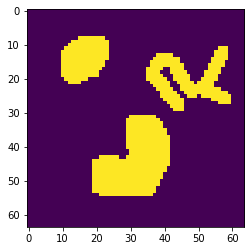

		16/2		16/4		16/8		8/2		8/4		4/2
label1		0.0216		0.0412		0.0030		0.0216		0.0412		0.0608
label2		0.2291		0.2232		0.2292		0.2293		0.2352		0.2291
label3		0.1403		0.0600		0.0513		0.1403		0.0600		0.1403


		16/2		16/4		16/8		8/2		8/4		4/2
label1		0.2110		0.1610		0.1453		0.2110		0.1610		0.2110
label2		0.0185		0.0181		0.0156		0.0059		0.0054		0.0009


		16/2		16/4		16/8		8/2		8/4		4/2
label1		0.2402		0.2284		0.2175		0.2402		0.2284		0.2402
label2		0.0192		0.0188		0.0166		0.0052		0.0048		0.0009


In [17]:
image_transform = dataset.datasets[0].transform

labels: list[str] = []
for bn_gt in bottlenecks.__reversed__():
    for bn_lt in bottlenecks:
        if bn_lt >= bn_gt:
            continue

        labels.append(f"{bn_gt}/{bn_lt}")

test_mask_labels = { 1: 3, 2: 2, 3: 2 }

for mask_idx, n_labels in test_mask_labels.items():
    path = f"data/test_mask{mask_idx}.png"
    img = plt.imread(path)
    plt.imshow(img)
    plt.show()
    
    losses = {}
    for i in range(1, n_labels+1):
        results = { j: test_mask(model, path, label=i) for j, model in models.items() }

        save_image(torch.cat([comp_data for _, _, comp_data in results.values()], dim=1).cpu(), f'results/test_mask_{mask_idx}_label{i}.png', nrow=3)    
        
        for bn_gt in bottlenecks.__reversed__():
            for bn_lt in bottlenecks:
                if bn_lt >= bn_gt:
                    continue

                # print(f"\tbn{bn_gt}/bn{bn_lt:<2}\t{(results[bn_gt][0]/results[bn_lt][0]):.4f}")
                metric = f"{1 - (results[bn_gt][0] - np.abs(results[bn_gt][0] - results[bn_lt][0])):.4f}"

                if losses.get(i) is None:
                    losses[i] = [metric]
                else:
                    losses[i].append(metric)

    print("\t\t" + '\t\t'.join(labels))
    for i in range(1, n_labels+1):
        print(f"label{i}\t\t" + '\t\t'.join(losses[i]))


$$
ACC_{lower} := \text{accuracy of the lower bottleneck VAE reconstruction} \\
ACC_{higher} := \text{accuracy of the higher bottleneck VAE reconstruction} \\
$$
$$
complexity = 1 - (ACC_{higher} - abs(ACC_{higher} - ACC_{lower}))
$$

In [14]:
def complexity_measure(
    model_gb: nn.Module,
    model_lb: nn.Module,
    img: Tensor,
    epsilon=0.4,
    save_preliminary=False,
):
    model.eval()

    with torch.no_grad():
        mask = img.to(device)
        recon_gb, _, _ = model_gb(mask)
        recon_lb, _, _ = model_lb(mask)

        recon_bits_gb = recon_gb.view(-1, 64, 64).cpu() > epsilon
        recon_bits_lb = recon_lb.view(-1, 64, 64).cpu() > epsilon
        mask_bits = mask[0].cpu() > 0

        if save_preliminary:
            save_image(
                torch.stack([mask_bits.float(), recon_bits_gb.float(), recon_bits_lb.float()]).cpu(),
                f"results/mask_recon{model_gb.bottleneck}_{model_lb.bottleneck}.png",
            )
            save_image(
                torch.stack(
                    [
                        (mask_bits & recon_bits_gb).float(),
                        (recon_bits_gb & ~mask_bits).float(),
                        (mask_bits & recon_bits_lb).float(),
                        (recon_bits_lb & ~mask_bits).float(),
                    ]
                ).cpu(),
                f"results/tp_fp_recon{model_gb.bottleneck}_{model_lb.bottleneck}.png",
            )

        tp_gb = (mask_bits & recon_bits_gb).sum()
        fp_gb = (recon_bits_gb & ~mask_bits).sum()
        tp_lb = (mask_bits & recon_bits_lb).sum()
        fp_lb = (recon_bits_lb & ~mask_bits).sum()

        prec_gb = tp_gb / (tp_gb + fp_gb)
        prec_lb = tp_lb / (tp_lb + fp_lb)
        complexity = 1 - (prec_gb - np.abs(prec_gb - prec_lb))

        return complexity


def alt_complexity_measure(
    model_gb: nn.Module, model_lb: nn.Module, img: Tensor, epsilon=0.4
):
    model.eval()

    with torch.no_grad():
        mask = img.to(device)
        recon_gb, _, _ = model_gb(mask)
        recon_lb, _, _ = model_lb(mask)

        bce_gb = F.binary_cross_entropy(recon_gb, mask.view(-1, 4096), reduction="sum")
        bce_lb = F.binary_cross_entropy(recon_lb, mask.view(-1, 4096), reduction="sum")

        recon_bits_gb = recon_gb.view(-1, 64, 64).cpu().numpy() > epsilon
        recon_bits_lb = recon_lb.view(-1, 64, 64).cpu().numpy() > epsilon
        mask_bits = mask.cpu().numpy() > 0

        tp_gb = (mask_bits & recon_bits_gb).sum()
        fp_gb = (recon_bits_gb & ~mask_bits).sum()
        tp_lb = (mask_bits & recon_bits_lb).sum()
        fp_lb = (recon_bits_lb & ~mask_bits).sum()

        prec_gb = tp_gb / (tp_gb + fp_gb)
        prec_lb = tp_lb / (tp_lb + fp_lb)
        complexity = 1 - (prec_gb - np.abs(prec_gb - prec_lb))

        return complexity


def plot_samples(masks: Tensor, complexities: npt.NDArray):
    dpi = 150
    rows = cols = 20
    total = rows * cols
    n_samples, _, _, _ = masks.shape

    if total != n_samples:
        raise Exception("shape mismatch")

    fig = plt.figure(figsize=(32, 16), dpi=dpi)
    for idx in np.arange(n_samples):
        ax = fig.add_subplot(rows, cols, idx + 1, xticks=[], yticks=[])

        plt.imshow(masks[idx][0], cmap=plt.cm.gray, extent=(0, 63, 0, 63))
        ax.set_title(
            f"{complexities[idx]:.4f}",
            fontdict={"fontsize": 6, "color": "orange"},
            y=0.35,
        )

    fig.patch.set_facecolor("#292929")
    height_px = 64 * rows
    width_px = 64 * cols
    fig.set_size_inches(width_px / (dpi / 2), height_px / (dpi / 2), forward=True)
    fig.tight_layout(pad=0)

    return fig


def visualize_sort(dataset, model_gb: nn.Module, model_lb: nn.Module):
    sampler = RandomSampler(dataset, replacement=True, num_samples=400)
    data_loader = DataLoader(dataset, batch_size=1, sampler=sampler)

    masks = torch.zeros((400, 1, 64, 64))
    complexities = torch.zeros((400,))
    for i, (mask, _) in enumerate(data_loader, 0):
        masks[i] = mask[0]

        complexity = complexity_measure(model_gb, model_lb, mask, save_preliminary=True)
        input()
        complexities[i] = complexity

    sort_idx = np.argsort(np.array(complexities))
    masks_sorted = masks.numpy()[sort_idx]

    return plot_samples(masks_sorted, complexities[sort_idx])


for bn_gt in bottlenecks.__reversed__():
    for bn_lt in bottlenecks:
        if bn_lt >= bn_gt:
            continue

        print(bn_gt, bn_lt)

        for i in range(1):
            figure = visualize_sort(dataset, models[bn_gt], models[bn_lt])
            figure.savefig(f"results/{bn_gt}_to_{bn_lt}_sample{i}.png")
            figure.clear()
            plt.close(figure)


16 2


KeyboardInterrupt: Interrupted by user